In [2]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

import math

### Part C

Diffusion model for sklearn digits

In [3]:
# Load data
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0    # 0–1
data = torch.from_numpy(X)

n_samples, x_dim = data.shape

device = "cuda" if torch.cuda.is_available() else "cpu"
data = data.to(device)

Training diffusion model...
Epoch 0 | Loss: 1.0152
Epoch 250 | Loss: 0.2339
Epoch 500 | Loss: 0.2064
Epoch 750 | Loss: 0.2189
Epoch 1000 | Loss: 0.1805
Epoch 1250 | Loss: 0.2028
Epoch 1500 | Loss: 0.1827
Epoch 1750 | Loss: 0.1962
Epoch 2000 | Loss: 0.2068
Epoch 2250 | Loss: 0.1594
Epoch 2500 | Loss: 0.1987
Epoch 2750 | Loss: 0.2003


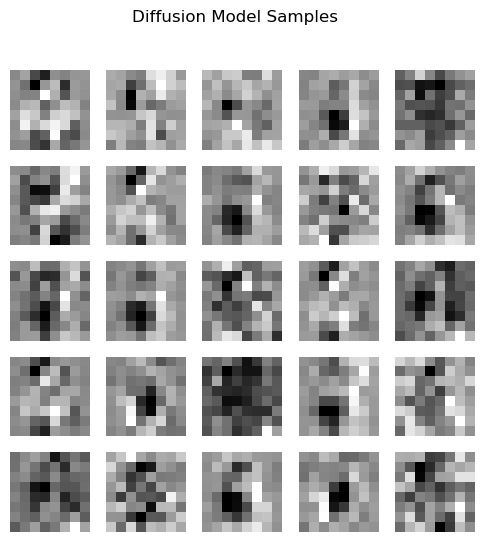

In [4]:
# -----------------------------------
# Cosine schedule from Lab 8b
# -----------------------------------
def get_cosine_schedule(T, s=0.008):
    t = torch.linspace(0, T, T+1)
    f_t = torch.cos(((t / T) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = f_t / f_t[0]
    alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = 1 - alphas
    betas = torch.clamp(betas, 0.0001, 0.9999)
    return 1 - betas

T = 300
alphas = get_cosine_schedule(T)
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# -----------------------------------
# Forward diffusion (Lab 8b)
# -----------------------------------
def forward_diffusion_sample(x_0, t):
    noise = torch.randn_like(x_0)
    return (
        sqrt_alphas_cumprod[t].view(-1, 1) * x_0 +
        sqrt_one_minus_alphas_cumprod[t].view(-1, 1) * noise,
        noise
    )

# -----------------------------------
# Noise predictor (Lab 8b style)
# -----------------------------------
class NoisePredictor(nn.Module):
    def __init__(self, T, x_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, x_dim)
        )
        self.T = T

    def forward(self, x, t):
        t_norm = (t.float() / self.T).view(-1, 1)
        xt = torch.cat([x, t_norm], dim=1)
        return self.net(xt)

model = NoisePredictor(T, x_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# -----------------------------------
# Training
# -----------------------------------
batch_size = 128
epochs = 3000
print("Training diffusion model...")

for epoch in range(epochs):
    idx = torch.randperm(n_samples)[:batch_size]
    x0 = data[idx]
    t = torch.randint(0, T, (batch_size,), device=device).long()

    xt, noise = forward_diffusion_sample(x0, t)
    pred = model(xt, t)

    loss = loss_fn(pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 250 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# -----------------------------------
# Reverse diffusion sampling
# -----------------------------------
@torch.no_grad()
def sample(model, n=25):
    model.eval()
    z = torch.randn((n, x_dim), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        pred = model(z, t_tensor)

        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        z = coeff1 * (z - coeff2 * pred)

        if t > 0:
            sigma = torch.sqrt(1 - alpha_t)
            z += sigma * torch.randn_like(z)

    return z

generated = sample(model, n=25).cpu().numpy()

# -----------------------------------
# Plot generated digits
# -----------------------------------
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for ax, img in zip(axes.flatten(), generated):
    ax.imshow(img.reshape(8, 8), cmap="gray")
    ax.axis("off")

plt.suptitle("Diffusion Model Samples")
plt.show()
